# Model comparison

In this notebook we perform Bayesian model comparison on several subset models, in two frameworks: MCMC (models fitted with HMC) and Variational Inference (models fitted with ADVI).
We consider a full model, where all orignal parameters are kept in the model, and subset models in which one of the  the coupling parameters is set to zero. We compare models fitted with HMC using criterion such as AIC, BIC, ([1]) and the more approriate WAIC and LOO ([2], [3]). Models fitted with ADVI can be compared with Evidence lower bound (ELBO), which is the negative Free Energy ([4]), and serves as a lower bound on the log likelihood.

References :

[1] Penny WD. Comparing dynamic causal models using AIC, BIC and free energy. Neuroimage. 2012 Jan 2;59(1):319-30. doi: 10.1016/j.neuroimage.2011.07.039. Epub 2011 Jul 27. PMID: 21864690; PMCID: PMC3200437.

[2] Watanabe, S. A Widely Applicable Bayesian Information Criterion. Journal of Machine Learning Research. 2013; 14: 867–897.

[3] Vehtari, A., Gelman, A. & Gabry, J. Practical Bayesian model evaluation using leave-one-out cross-validation and WAIC. Stat Comput 27, 1413–1432 (2017). https://doi.org/10.1007/s11222-016-9696-4

[4] Zeidman, P., Friston, K., Parr, T. A primer on Variational Laplace (VL), NeuroImage. 2023. Volume 279, 120310, ISSN 1053-8119, https://doi.org/10.1016/j.neuroimage.2023.120310.

In [1]:
import os
import sys
import time
import errno
import timeit
import pathlib

import numpy as np
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns 
sns.set_context("paper", font_scale=1.5, rc={"axes.labelsize":16})
colors = ['blue', 'darkorange', 'green', 'magenta', 'cyan']

import pickle
import pandas as pd
from scipy.stats import norm

In [2]:
import jax 
import jax.numpy as jnp
from jax import grad, vmap, lax, random
from jax.experimental.ode import odeint

In [3]:
import numpyro as npr
from numpyro import sample, plate, handlers
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive, init_to_value, SVI, Trace_ELBO
from numpyro.infer.autoguide import AutoLaplaceApproximation
from numpyro.optim import Adam

/mnt/data/tng/phd/DCM/DCM_ERP_new/.pymc_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
npr.set_platform("cpu")

In [5]:
import cmdstanpy

In [6]:
#See the dependency at last cell!
for pckg in [np, jax, npr, cmdstanpy, az] :
    print(f" {pckg.__name__} version: {pckg.__version__}")

 numpy version: 1.24.3
 jax version: 0.4.23
 numpyro version: 0.14.0
 cmdstanpy version: 1.2.2
 arviz version: 0.18.0


In [7]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action="ignore", category=FutureWarning)

In [8]:
cwd = os.getcwd()
main_path = str(pathlib.Path.cwd().parent)
sys.path.append(main_path) # Path to import the model and solver

output_dir= cwd + '/output_numpyro/'
! mkdir -p $output_dir

In [9]:
from Helper.ERPhelper import *
from Helper.report_advi import convergence_advi, advi_elbo
from ForwardModel.ERPmodel_JAX import DCM_ERPmodel, odeint_euler, odeint_heun, odeint_rk4

In [10]:
def aic(log_lik, nprms):
    return 2 * nprms - 2 * np.max(log_lik)

def aicc(log_lik, nprms, ndata):
    return aic(log_lik, nprms) + 2 * nprms * (nprms + 1) / (ndata - nprms - 1)

def bic(log_lik, nparams, ndata):
    k = nparams
    n = ndata
    return -2 * np.max(log_lik) + k * np.log(n)

def rmse(pred, target) :
    return np.sqrt(np.mean((pred-target)**2))

## Background

### Motivation

Ordinary differential equation models (ODEs) are used in a variety of science and engineering domains to model the time evolution of physical variables.  A natural choice to estimate the values and uncertainty of model parameters given experimental data is Bayesian inference.  However, ODEs can be challenging to specify and solve in the Bayesian setting, therefore, this notebook steps through multiple methods for solving an ODE inference problem using JAX's Odeint. Alternative is to use diffrax, which can be found in forward simulations in the repo. The neural mass model used in this example has often been used in dynamical causal modeling and other approaches to fit various neuroimaging data such as ERP/EEG/MEG.

### Neural Mass Model

The mode of Olivier David et al describes the interaction between theree neural populations of pyramidal (x9), 
inhibitory interneuron (x7) 
spiny-stellate cells (x1).

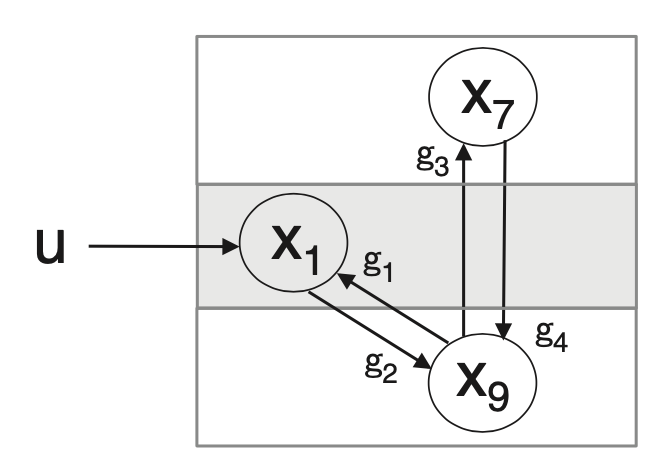

In [11]:
from IPython.display import Image
Image(filename='../Images/model.png', width=400)

This ODE given by:




\begin{equation}
    \begin{aligned}
    \dot x_1(t) &= x_4 (t) \\
    \dot x_2(t) &= x_5(t) \\
    \dot x_3(t) &= \dfrac{h_e}{\tau_e} \left( g_1 \left( 
    \dfrac{1}{\exp^{-0.56 x_9 (t - \delta)} + 1} - 0.5 \right) + u \right) - \dfrac{x_1(t)}{\tau_e^2} - \dfrac{2 x_4(t)}{\tau_e} \\
    \dot x_5(t) &= \dfrac{g_2 h_e}{\tau_e}  \left( 
    \dfrac{1}{\exp^{-0.56 x_1 (t - \delta)} + 1} -0.5 \right) - \dfrac{x_2(t)}{\tau_e^2} - \dfrac{2 x_5(t)}{\tau_e} \\
    \dot x_6(t) &= \dfrac{g_4 h_i}{\tau_i}  \left( 
    \dfrac{1}{\exp^{-0.56 x_7 (t - \delta)} + 1} -0.5 \right) - \dfrac{x_3(t)}{\tau_i^2} - \dfrac{2 x_6(t)}{\tau_i} \\
    \dot x_7(t) &= x_8(t) \\
    \dot x_8(t) &= \dfrac{g_3 h_e}{\tau_e}  \left( 
    \dfrac{1}{\exp^{-0.56 x_9 (t - \delta)} + 1} -0.5 \right) - \dfrac{x_7(t)}{\tau_e^2} - \dfrac{2 x_8(t)}{\tau_e} \\
    \dot x_9(t) &= x_5(t) - x_6(t)
\end{aligned}
\end{equation}




The state vector $X(t)=[x_1(t), ...x_9(t)]$ comprises the densities of activity of neural populations. Parameters $\boldsymbol{\theta}=[g_1, g_2, g_3, g_4, \delta,\tau_i, h_i, \tau_e, h_e, u ]$ are the unknowns that we wish to infer from experimental observations.

$x(0)$ represents the initial values of the states needed to solve the ODE and is fixed to zero for all variables.

The unknown model parameters represent the following:

* $g_1, g_2, g_3, g_4$ are connection strengths.
* $\delta$ is the intrinsic delay.
* $h_{e,i}$ represents the maximum amplitude of excitatory (e) and inhibitory (i) post-synaptic potentials.
* $\tau_{e, i}$ are the rate constants for excitatory and inhibitory synaptic inputs, respectively.
* $u$  represents the input to each neural population

## Simulator

In [12]:
rng_key = random.PRNGKey(0)

In [13]:
tend = 200.0
dt = 0.1
t0 = 0.0
ts = np.arange(t0, tend + dt, dt)
nt = ts.shape[0]

In [14]:
ns = 9
x_init=np.zeros((ns))

In [15]:
theta_true = np.array([0.42, 0.76, 0.15, 0.16, 12.13, 7.77, 27.87, 5.77, 1.63, 3.94])
n_params = theta_true.shape[0]

In [16]:
my_var_names = ['g_1', 'g_2', 'g_3', 'g_4', 'delta', 'tau_i', 'h_i', 'tau_e', 'h_e', 'u']

In [17]:
@jax.jit
def ERP_JAXOdeintSimulator(x_init, ts, params):

    xs_rk4 = odeint_euler(DCM_ERPmodel, x_init, ts, params)    
    x_py=xs_rk4[:,8]
    
    return x_py

The initial compilation takes a bit of time, but after that, it flies through the air!

In [18]:
start_time = time.time()

xpy_jax=ERP_JAXOdeintSimulator(x_init, ts, theta_true)

print("simulation with compiling took (sec):" , (time.time() - start_time))

simulation with compiling took (sec): 0.4291954040527344


In [19]:
start_time = time.time()

xpy_jax=ERP_JAXOdeintSimulator(x_init, ts, theta_true)

print("simulation using JAX's JIT took (sec):" , (time.time() - start_time))

simulation using JAX's JIT took (sec): 0.001936197280883789


## Synthetic Observation

We assume that we only have access to the activity of pyramidal neurons, and for the sake of speeding the computational time, we downsample the simuations.

In [20]:
#observation noise
sigma_true = 0.1 

In [21]:
xpy_jax = ERP_JAXOdeintSimulator(x_init, ts, theta_true)
x_noise = np.random.normal(loc=0, scale=sigma_true, size=xpy_jax.shape)
x_py = xpy_jax + x_noise

In [22]:
#downsampling
ds=10

In [23]:
ts_obs=ts[::ds]
xpy_obs=x_py[::ds]
nt_obs=int(x_py[::ds].shape[0])

In [24]:
ts_obs.shape, xpy_obs.shape, nt_obs

((201,), (201,), 201)

In [25]:
data= {'ns': ns, 'n_params': n_params,
       'nt_obs': nt_obs, 'ds': ds, 'ts': ts, 'ts_obs': ts_obs, 'dt': dt, 'nt': nt_obs, 
       'x_init': x_init, 'obs_err': sigma_true, 'xpy_obs': xpy_obs,
      }

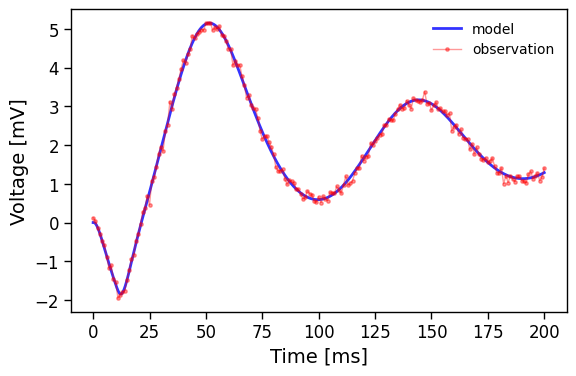

In [26]:
plot_observation(ts, xpy_jax, ts_obs, xpy_obs);

In [27]:
xpy_models = []
theta_models = [theta_true.copy() for i in range(7)]

In [28]:
for i in range(4) :
    theta_models[i][i] = 0
    xpy_models.append(ERP_JAXOdeintSimulator(x_init, ts, theta_models[i]))

In [29]:
theta_models[4][0] = 0
theta_models[4][2] = 0
xpy_models.append(ERP_JAXOdeintSimulator(x_init, ts, theta_models[4]))

theta_models[5][0] = 0
theta_models[5][3] = 0
xpy_models.append(ERP_JAXOdeintSimulator(x_init, ts, theta_models[5]))

theta_models[6][2] = 0
theta_models[6][3] = 0
xpy_models.append(ERP_JAXOdeintSimulator(x_init, ts, theta_models[6]))

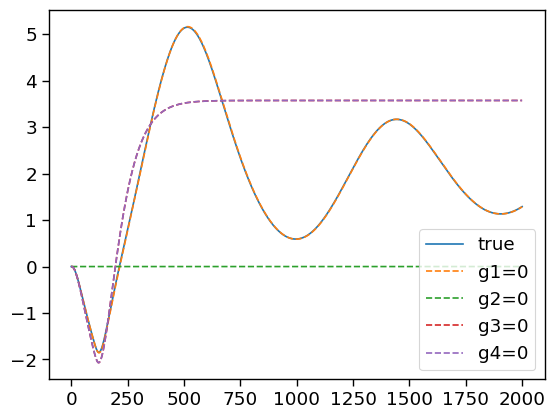

In [30]:
plt.plot(xpy_jax, label='true')
for i in range(4) :
    plt.plot(xpy_models[i], '--', label='g' + str(i+1) + '=0')
plt.legend() ;

# Inference with Hamiltonian Monte Carlo / No-U-Turn Sampler (HMC NUTS)

## Prior

Since all the parameters are positive, we place Gamma prior, according to Refs [3,4].

In [31]:
shape=[18.16, 29.9, 29.14, 30.77, 22.87, 34.67, 20.44, 33.02, 24.17, 23.62]
scale=[0.03, 0.02, 0.005, 0.007, 0.51, 0.23, 0.96, 0.16, 0.07, 0.13]
rate = 1. / np.array(scale)

In [32]:
prior_specs = dict(shape=shape, rate=rate)

In [33]:
def model(data, prior_specs, model_id=0):
    #Data
    dt = data['dt']
    ts = data['ts']
    ds = data['ds']
    nt_obs = data['nt_obs']
    x_init = data['x_init']
    obs_err= data['obs_err']
    obs = data['xpy_obs']

    # Prior   
    
    if model_id == 1 :
        g_1 = 0
    else :
        g_1 = npr.sample('g_1', dist.Gamma(prior_specs['shape'][0], prior_specs['rate'][0])) 
    if model_id == 2 :
        g_2 = 0        
    else :
        g_2 = npr.sample('g_2', dist.Gamma(prior_specs['shape'][1], prior_specs['rate'][1]))
    if model_id == 3 :
        g_3 = 0
    else :
        g_3 = npr.sample('g_3', dist.Gamma(prior_specs['shape'][2], prior_specs['rate'][2]))
    if model_id == 4:
        g_4 = 0
    else :
        g_4 = npr.sample('g_4', dist.Gamma(prior_specs['shape'][3], prior_specs['rate'][3]))
        
    delta = npr.sample('delta', dist.Gamma(prior_specs['shape'][4], prior_specs['rate'][4]))
    tau_i = npr.sample('tau_i', dist.Gamma(prior_specs['shape'][5], prior_specs['rate'][5]))
    h_i = npr.sample('h_i', dist.Gamma(prior_specs['shape'][6], prior_specs['rate'][6]))
    tau_e = npr.sample('tau_e', dist.Gamma(prior_specs['shape'][7], prior_specs['rate'][7]))
    h_e = npr.sample('h_e', dist.Gamma(prior_specs['shape'][8], prior_specs['rate'][8]))
    u = npr.sample('u', dist.Gamma(prior_specs['shape'][9], prior_specs['rate'][9]))
     
    #Parameters    
    params_samples=[g_1, g_2, g_3, g_4, delta, tau_i,  h_i, tau_e, h_e, u]
    
    #Forward model
    xpy_hat=ERP_JAXOdeintSimulator(x_init, ts, params_samples)[::ds]
    
    # Likelihood
    with plate('data', size=nt_obs):
        xpy_model = npr.deterministic('xpy_model', xpy_hat)
        npr.sample('xpy_obs', dist.Normal(xpy_model, obs_err), obs=obs)
        xpy_ppc = npr.sample('xpy_ppc', dist.Normal(xpy_model, obs_err))

### Prior predictive check

#### Full model (model 0)

In [34]:
n_ = 100
prior_predictive = Predictive(model, num_samples=n_)
prior_predictions = prior_predictive(rng_key, data, prior_specs)

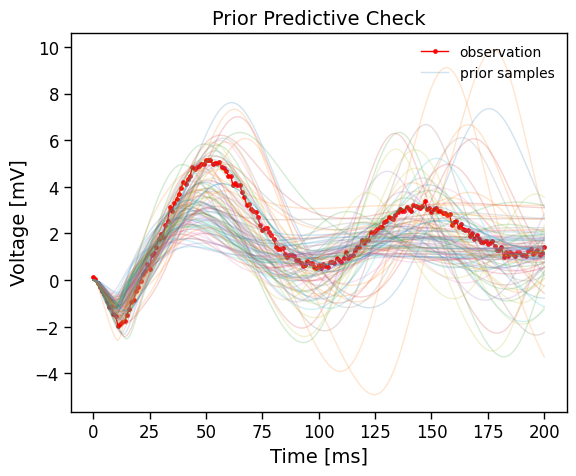

In [35]:
title='Prior Predictive Check'
plot_priorcheck(ts_obs, xpy_obs, prior_predictions, n_, title);

#### Model 1 : g1 = 0

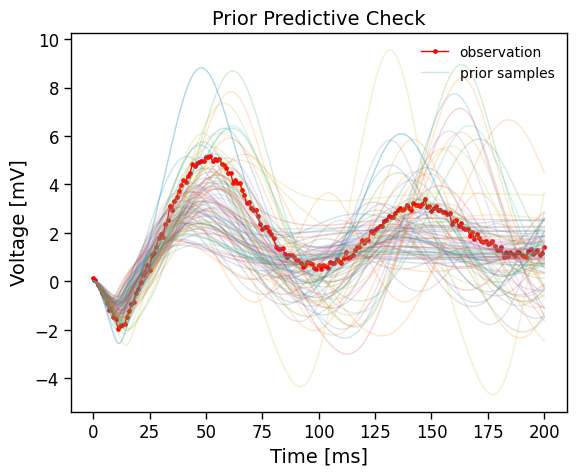

In [36]:
n_ = 100
prior_predictive = Predictive(model, num_samples=n_)
prior_predictions = prior_predictive(rng_key, data, prior_specs, 1)
title='Prior Predictive Check'
plot_priorcheck(ts_obs, xpy_obs, prior_predictions, n_, title);

#### Model 2 : g2 = 0

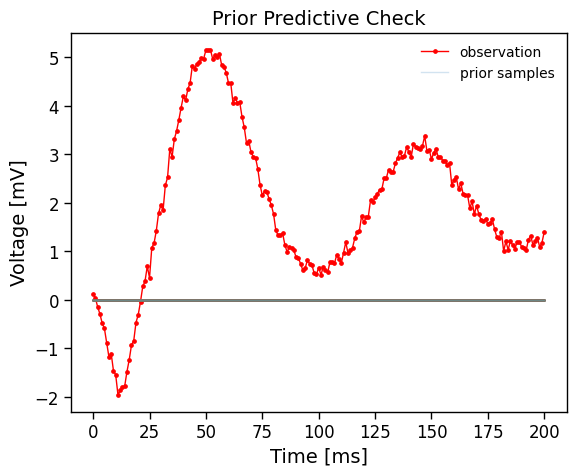

In [37]:
n_ = 100
prior_predictive = Predictive(model, num_samples=n_)
prior_predictions = prior_predictive(rng_key, data, prior_specs, 2)
title='Prior Predictive Check'
plot_priorcheck(ts_obs, xpy_obs, prior_predictions, n_, title);

#### Model 3 : g3 = 0

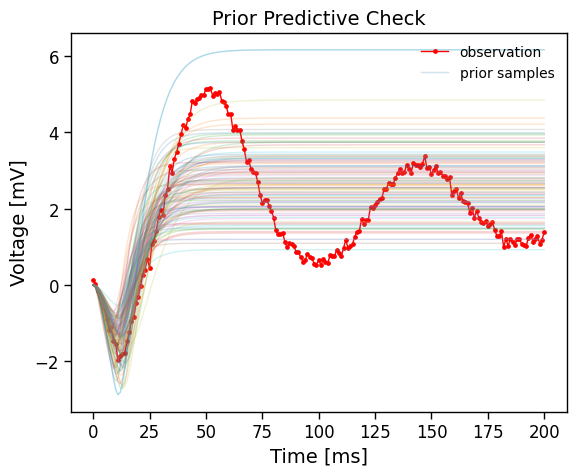

In [38]:
n_ = 100
prior_predictive = Predictive(model, num_samples=n_)
prior_predictions = prior_predictive(rng_key, data, prior_specs, 3)
title='Prior Predictive Check'
plot_priorcheck(ts_obs, xpy_obs, prior_predictions, n_, title);

#### Model 4 : g4 = 0

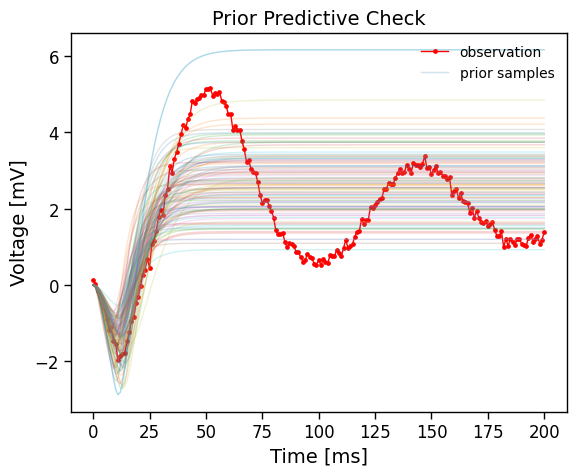

In [39]:
n_ = 100
prior_predictive = Predictive(model, num_samples=n_)
prior_predictions = prior_predictive(rng_key, data, prior_specs, 4)
title='Prior Predictive Check'
plot_priorcheck(ts_obs, xpy_obs, prior_predictions, n_, title);

## NUTS sampling 

In [40]:
n_warmup, n_samples, n_chains= 200, 200, 4

In [41]:
for imodel in range(5) :
    
    #prior and initialization
    n_ = 100
    prior_predictive = Predictive(model, num_samples=n_)
    prior_predictions = prior_predictive(rng_key, data, prior_specs,  model_id=imodel)
    tails_5th_percentile=tails_percentile(my_var_names, prior_predictions, 0.05)
    init_to_low_prob = init_to_value(values=tails_5th_percentile)
    
    # NUTS set up
    kernel = NUTS(model, max_tree_depth=10,  dense_mass=False, adapt_step_size=True, init_strategy=init_to_low_prob)
    mcmc= MCMC(kernel, num_warmup=n_warmup, num_samples=n_samples, num_chains=n_chains, chain_method='parallel')
    
    #RUN NUTS
    start_time = time.time()
    mcmc.run(rng_key, data, prior_specs, model_id=imodel, 
             extra_fields=('potential_energy', 'num_steps', 'diverging'))
    print("Model " + str(imodel) + " using NUTS' Numpyro took (sec):" , (time.time() - start_time))
    
    #save 
    with open(output_dir + "model" + str(imodel) + ".pickle", "wb") as output_file:
        pickle.dump(mcmc, output_file)

sample: 100%|█| 400/400 [00:58<00:00,  6.88it/s, 511 steps of size 6.81e-03. acc
sample: 100%|█| 400/400 [00:55<00:00,  7.15it/s, 511 steps of size 9.04e-03. acc
sample: 100%|█| 400/400 [00:56<00:00,  7.08it/s, 511 steps of size 8.59e-03. acc
sample: 100%|█| 400/400 [00:57<00:00,  6.95it/s, 511 steps of size 7.19e-03. acc


Model 0 using NUTS' Numpyro took (sec): 231.61193704605103


sample: 100%|█| 400/400 [00:57<00:00,  7.00it/s, 511 steps of size 7.47e-03. acc
sample: 100%|█| 400/400 [00:54<00:00,  7.40it/s, 511 steps of size 7.65e-03. acc
sample: 100%|█| 400/400 [00:54<00:00,  7.40it/s, 511 steps of size 7.92e-03. acc
sample: 100%|█| 400/400 [00:54<00:00,  7.30it/s, 511 steps of size 8.94e-03. acc


Model 1 using NUTS' Numpyro took (sec): 222.2244017124176


sample: 100%|█| 400/400 [00:04<00:00, 88.63it/s, 15 steps of size 3.67e-01. acc.
sample: 100%|█| 400/400 [00:04<00:00, 89.01it/s, 15 steps of size 3.57e-01. acc.
sample: 100%|█| 400/400 [00:04<00:00, 88.66it/s, 15 steps of size 3.99e-01. acc.
sample: 100%|█| 400/400 [00:04<00:00, 89.91it/s, 15 steps of size 3.76e-01. acc.


Model 2 using NUTS' Numpyro took (sec): 19.8575599193573


sample: 100%|█| 400/400 [00:33<00:00, 11.84it/s, 255 steps of size 1.67e-02. acc
sample: 100%|█| 400/400 [00:35<00:00, 11.16it/s, 255 steps of size 1.31e-02. acc
sample: 100%|█| 400/400 [00:31<00:00, 12.53it/s, 255 steps of size 1.79e-02. acc
sample: 100%|█| 400/400 [00:32<00:00, 12.27it/s, 255 steps of size 1.63e-02. acc


Model 3 using NUTS' Numpyro took (sec): 136.05975317955017


sample: 100%|█| 400/400 [00:33<00:00, 12.02it/s, 255 steps of size 1.63e-02. acc
sample: 100%|█| 400/400 [00:30<00:00, 13.11it/s, 255 steps of size 1.80e-02. acc
sample: 100%|█| 400/400 [00:33<00:00, 12.08it/s, 255 steps of size 1.78e-02. acc
sample: 100%|█| 400/400 [00:32<00:00, 12.21it/s, 255 steps of size 1.62e-02. acc


Model 4 using NUTS' Numpyro took (sec): 131.68928027153015


## Loading outputs

In [42]:
models_traces = []
for imodel in range(5) :
    with open(output_dir + "model" + str(imodel) + ".pickle", "rb") as input_file:
        mcmc = pickle.load(input_file)
    models_traces.append(az.from_numpyro(mcmc))

### Fit to the data

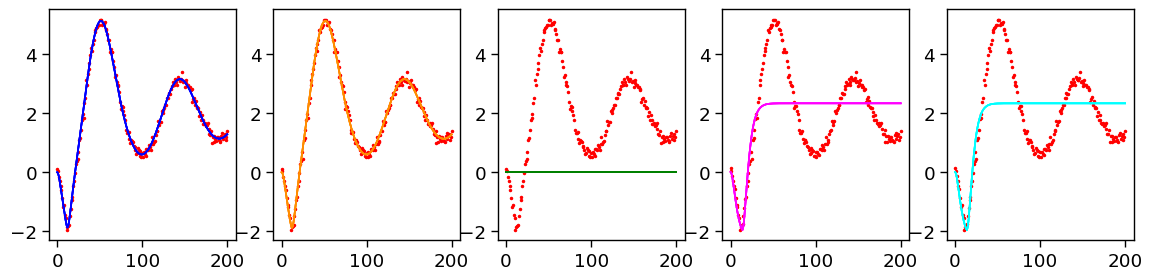

In [43]:
fig, ax = plt.subplots(ncols=5, figsize=(14, 3))
for i in range(5) :
    ax[i].plot(xpy_obs, 'r.', markersize=3)
    xpy_fit = models_traces[i].posterior['xpy_model']
    for ichain in range(xpy_fit.shape[0]):
        ax[i].plot(xpy_fit[ichain].mean(axis=0), color=colors[i])

### Posterior distributions of parameters

In [44]:
prior_samples = prior_predictive(rng_key, data, prior_specs)

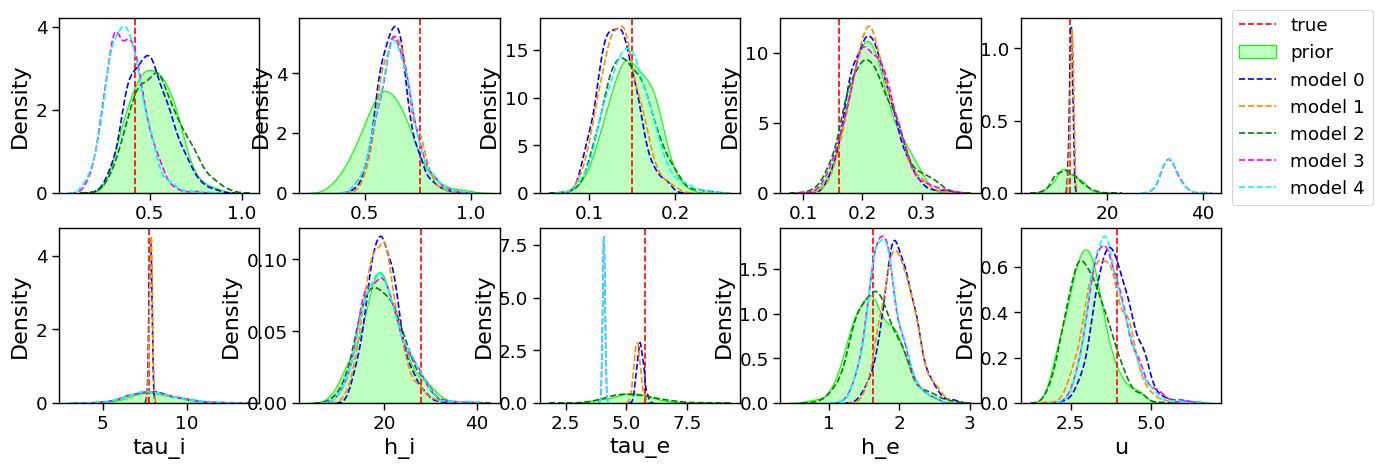

In [45]:
colors = ['blue', 'darkorange', 'green', 'magenta', 'cyan']

fig, ax = plt.subplots(ncols=5, nrows=2, figsize=(15, 5))

for iprm, prm in enumerate(my_var_names) : 
    a = ax[iprm//5, iprm%5]
    a.set_xlabel(prm)
    a.axvline(theta_true[iprm], color='r', label='true', linestyle='--')
    sns.kdeplot(prior_samples[prm], color='lime', shade=True, ax=a, label='prior')
    
    for imodel in range(5) :
        try :
            trace = az.extract(models_traces[imodel], var_names=prm)
            sns.kdeplot(trace, linestyle='--', color=colors[imodel], ax=a, label='model ' + str(imodel))
        except :
            continue

ax[0, 4].legend(loc='upper right', bbox_to_anchor=(1.8, 1.1)) ;

## Computing information criteria

### AIC

AIC = - 2 * ( Accuracy(model) − number of parameters)

$$AIC =-2\log p(data\mid \hat \theta_{mle})+2{n_{params}}$$

where $\log p(data\mid \hat \theta_{mle})$ is maximum likelihood


In [46]:
models_aic = []
for i in range(5) :
    if i == 0 :
        n_ = n_params
    else :
        n_ = n_params - 1
        
    models_aic.append(aic(-models_traces[i].sample_stats['lp'].values, n_))

### BIC

BIC = -2 * ( Accuracy(model) - 1/2  number of parameters * log(number of data points) )

$${BIC}=-2\log p(data\mid \hat \theta_{mle}) + {n_{params}}\log({n_{data}})$$

where $\log p(data\mid \hat \theta_{mle})$ is maximum likelihood

In [47]:
models_bic = []

for i in range(5) :
    if i == 0 :
        n_ = n_params
    else :
        n_ = n_params - 1
        
    models_bic.append(bic(-models_traces[i].sample_stats['lp'].values, 
                          n_,
                          models_traces[i].posterior.dims['xpy_model_dim_0']))

### WAIC

WAIC = -2 (log pointwise predictive density - effective number of parameters)

$${WAIC}=-2(lppd_{waic}-p_{eff})$$
with 
$$lppd_{waic}=\sum_{i=1}^{n} \log  (\dfrac{1}{S} \sum_{i=1}^{S} p(data_i \mid \theta^s))$$
and 
$$p_{eff}=\sum_{i=1}^{n}  V_{s=1}^S (\log p(data_i \mid \theta^s)) $$

, using the posterior draws $\theta^s$.

See [3] Vehtari, A., Gelman, A. & Gabry, J. Practical Bayesian model evaluation using leave-one-out cross-validation and WAIC. Stat Comput 27, 1413–1432 (2017). https://doi.org/10.1007/s11222-016-9696-4

In [48]:
models_waic = []
for trace in models_traces :
    waic = [az.waic(trace.sel(chain=[ichain]), scale='deviance').elpd_waic for ichain in range(4)]
    models_waic.append(waic)

### CV-LOO

$$lppd_{loo}=\sum_{i=1}^{n} \log \big(\dfrac{ \sum_{s=1}^{S} w_i^s p(y_i \mid \theta^s)}{\sum_{s=1}^{S} w_i^s})$$
where, $w_i^s, s=1,...,S$  is a vector of importance weights for each $i$th data point, and $\theta^s$ are the posterior draws.

$$loo = -2 * lppd_{loo}$$ to be on the same scale as WAIC.

See [3] Vehtari, A., Gelman, A. & Gabry, J. Practical Bayesian model evaluation using leave-one-out cross-validation and WAIC. Stat Comput 27, 1413–1432 (2017). https://doi.org/10.1007/s11222-016-9696-4

In [49]:
models_loo = []
for trace in models_traces :
    loo = [az.loo(trace.sel(chain=[ichain]), scale='deviance').elpd_loo for ichain in range(4)]
    models_loo.append(loo)

### Summarize

We put all criteria on the negative log scale. They were on the "deviance" scale, i.e. -2 log . The best model is the one that minimizes the deviance or negative log scale criteria.

In [50]:
model_names = ['full model', 'g_1 = 0', 'g_2 = 0', 'g_3 = 0', 'g_4 = 0']
models_ic = pd.DataFrame({'loo': 0.5*np.mean(models_loo, axis=1), 
                          'waic': 0.5*np.mean(models_waic, axis=1), 
                          'aic': 0.5*np.array(models_aic), 
                          'bic': 0.5*np.array(models_bic),
                          'model': model_names})

In [51]:
models_ic.to_csv('models_ic.csv')

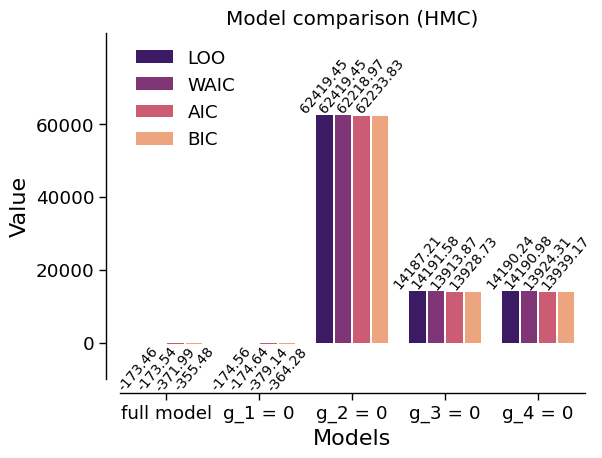

In [52]:
fig, ax = plt.subplots(figsize=(6, 4.5))
sns.barplot(models_ic.melt('model', var_name='criterion'), 
            x='model', y='value', hue='criterion', palette='magma', ax=ax, gap=.1)
for i in range(4) :
    ax.bar_label(ax.containers[i], fmt='%.2f', fontsize=10, rotation=50)
    
ax.set_ylim([-10000, 85000])
ax.set_yticks(range(0, 65000, 20000))   
ax.set_xticks(range(5))
ax.set_xticklabels(model_names)
ax.set_xlabel('Models')
ax.set_ylabel('Value')

h, l = ax.get_legend_handles_labels()
ax.legend(frameon=False, handles=h, labels=['LOO', 'WAIC', 'AIC', 'BIC'], loc='upper left')
ax.set_title('Model comparison (HMC)') 
sns.despine(offset=10) ;

# Inference with Automatic Differentiation Variational Inference (ADVI)

In [53]:
stan_data = data.copy()

In [54]:
stan_data['dt'] *= stan_data['ds']
stan_data['alpha'] =  -0.56
stan_data['prior_gamma_shape'] = prior_specs['shape']
stan_data['prior_gamma_rate'] = prior_specs['rate']

In [55]:
inits=tails_percentile(my_var_names, prior_samples, 0.05)

## ADVI full-rank

In [56]:
alg = 'fullrank'
advi_output_dir =  'output_advi/' + alg + '/'
! mkdir -p $advi_output_dir
print(advi_output_dir)

output_advi/fullrank/


In [58]:
for imodel in range(5) :
    
    model_name = 'DCM_ERP_model' + str(imodel) + '.stan'
    model = cmdstanpy.CmdStanModel(stan_file=model_name)
    model.compile()
    
    try :
        model.variational(data=stan_data, inits=inits, algorithm=alg, iter=200000, tol_rel_obj=0.00001,
                          output_dir=advi_output_dir, require_converged=False)
    except :
        model.variational(data=stan_data, inits=inits, algorithm=alg, iter=200000, tol_rel_obj=0.00001,
                          output_dir=advi_output_dir, require_converged=False)

### Loading ELBO

In [59]:
converged = np.zeros(5)
files_converged = []
ELBO_advi = []
models_index_advi = []

i=0
for files in os.listdir(advi_output_dir) :
    if files.endswith('.txt'):
        if convergence_advi(advi_output_dir + files) == 1:
            print(files)
            models_index_advi.append(files[13])
            converged[i] = 1
            i+=1
            files_converged.append(files[:-13])
            Iter, ELBO = advi_elbo(advi_output_dir + files)
            ELBO_advi.append(ELBO)
#ELBO_advi = np.array(ELBO_advi)

DCM_ERP_model2-20240528105650_0-stdout.txt
DCM_ERP_model0-20240528111148_0-stdout.txt
DCM_ERP_model3-20240527173702_0-stdout.txt
DCM_ERP_model4-20240527174613_0-stdout.txt
DCM_ERP_model1-20240528110026_0-stdout.txt


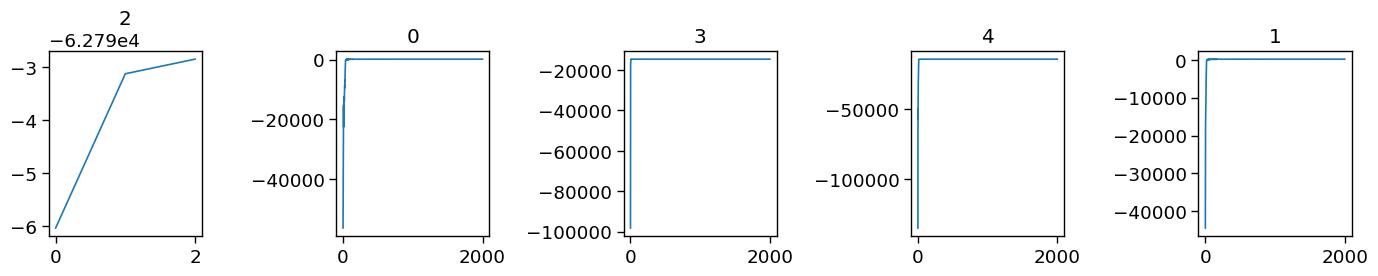

In [60]:
fig, ax = plt.subplots(ncols=5, figsize=(14, 3))
for i in range(5) :
    ax[i].plot(ELBO_advi[i])
    ax[i].set(title=models_index_advi[i])
fig.tight_layout()

In [61]:
max_elbo_fullrank = []
for i in range(5) :
    max_elbo_fullrank.append(np.max(ELBO_advi[i]))

In [62]:
max_elbo_fullrank_ordered=np.array(max_elbo_fullrank)[np.argsort(models_index_advi)]

In [63]:
max_elbo_fullrank_ordered

array([   149.475,    150.088, -62792.851, -14639.705, -14639.669])

### Loading posterior

In [64]:
files_converged_ordered = np.array(files_converged)[np.argsort(models_index_advi)]

In [65]:
traces_fullrank = [] 
for i in range(5) :
    traces_fullrank.append(az.from_cmdstan(advi_output_dir + 'DCM_ERP_model' + str(i) + '*.csv'))

### Fit to the data

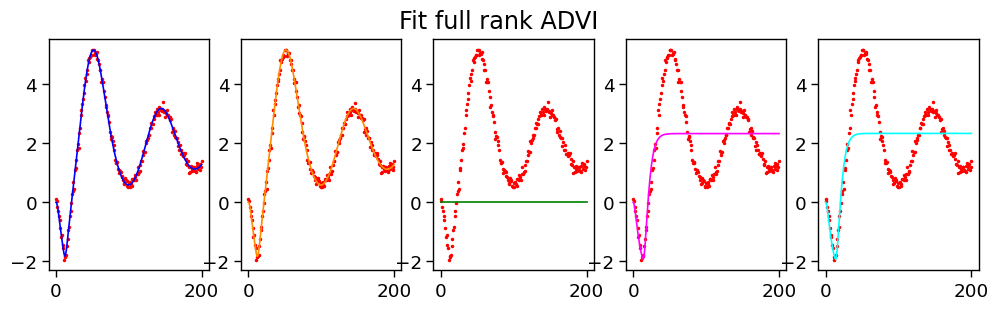

In [66]:
fig, ax = plt.subplots(ncols=5, figsize=(12, 3))
for i in range(5) :
    ax[i].plot(xpy_obs, 'r.', markersize=3)
    ax[i].plot(traces_fullrank[i].posterior['x_hat'].mean(axis=(0, 1)), color=colors[i])
fig.suptitle('Fit full rank ADVI') ;

### Posterior distributions of parameters

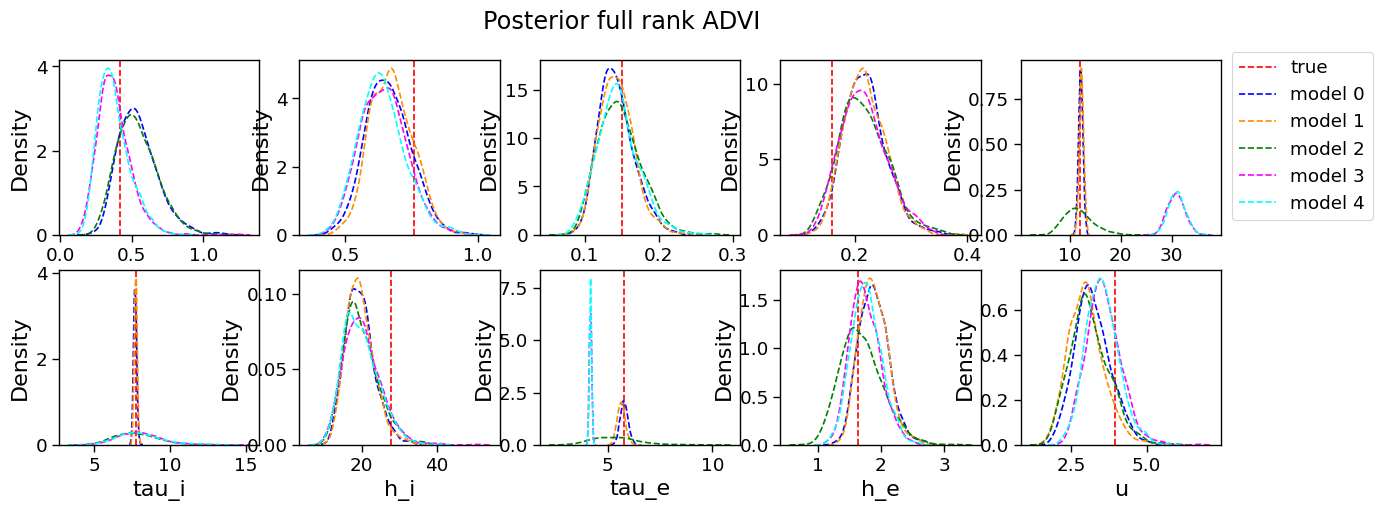

In [67]:
fig, ax = plt.subplots(ncols=5, nrows=2, figsize=(15, 5))

for iprm, prm in enumerate(my_var_names) : 
    a = ax[iprm//5, iprm%5]
    a.set_xlabel(prm)
    a.axvline(theta_true[iprm], color='r', label='true', linestyle='--')
    
    for imodel in range(5) :
        try :
            trace = az.extract(traces_fullrank[imodel].posterior, var_names=prm)
            sns.kdeplot(trace, linestyle='--', color=colors[imodel], ax=a, label='model ' + str(imodel))
        except :
            continue

ax[0, 4].legend(loc='upper right', bbox_to_anchor=(1.8, 1.1)) 
fig.suptitle('Posterior full rank ADVI');

## ADVI mean-field

In [68]:
alg = 'meanfield'
advi_output_dir =  'output_advi/' + alg + '/'
! mkdir -p $advi_output_dir
print(advi_output_dir)

output_advi/meanfield/


In [69]:
for imodel in range(5) :
    
    model_name = 'DCM_ERP_model' + str(imodel) + '.stan'
    model = cmdstanpy.CmdStanModel(stan_file=model_name)
    model.compile()
    
    try :
        model.variational(data=stan_data, inits=inits, algorithm=alg, iter=200000, tol_rel_obj=0.00001,
                          output_dir=advi_output_dir, require_converged=False)
    except :
        model.variational(data=stan_data, inits=inits, algorithm=alg, iter=200000, tol_rel_obj=0.00001,
                          output_dir=advi_output_dir, require_converged=False)

### Loading ELBO

In [70]:
converged = np.zeros(5)
files_converged = []
ELBO_advi = []
models_index_advi = []

i=0
for files in os.listdir(advi_output_dir) :
    if files.endswith('.txt'):
        if convergence_advi(advi_output_dir + files) == 1:
            print(files)
            models_index_advi.append(files[13])
            converged[i] = 1
            i+=1
            files_converged.append(files[:-13])
            Iter, ELBO = advi_elbo(advi_output_dir + files)
            ELBO_advi.append(ELBO)
#ELBO_advi = np.array(ELBO_advi)

DCM_ERP_model0-20240528155009_0-stdout.txt
DCM_ERP_model2-20240528120457_0-stdout.txt
DCM_ERP_model1-20240528115358_0-stdout.txt
DCM_ERP_model4-20240528121643_0-stdout.txt
DCM_ERP_model3-20240528162001_0-stdout.txt


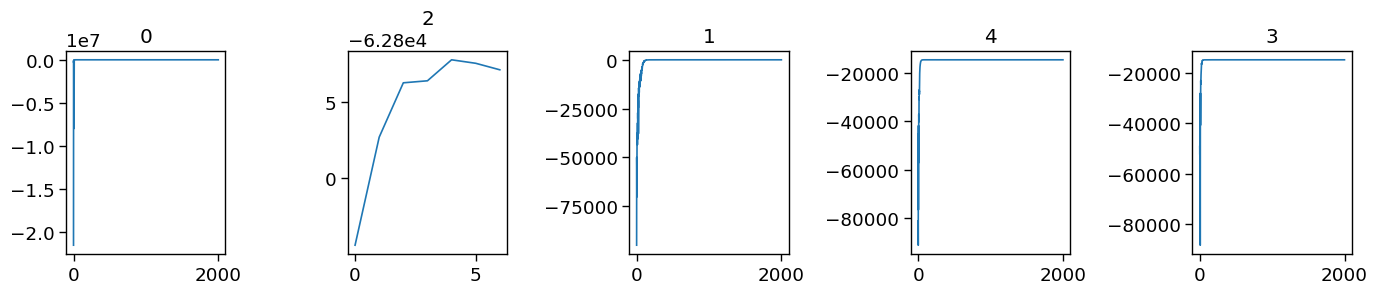

In [71]:
fig, ax = plt.subplots(ncols=5, figsize=(14, 3))
for i in range(5) :
    ax[i].plot(ELBO_advi[i])
    ax[i].set(title=models_index_advi[i])
fig.tight_layout()

In [72]:
max_elbo_meanfield = []
for i in range(5) :
    max_elbo_meanfield.append(np.max(ELBO_advi[i]))

In [73]:
max_elbo_meanfield_ordered = np.array(max_elbo_meanfield)[np.argsort(models_index_advi)]

In [74]:
max_elbo_meanfield_ordered

array([   134.717,    135.193, -62792.229, -14644.831, -14644.82 ])

### Loading posterior

In [75]:
files_converged_ordered = np.array(files_converged)[np.argsort(models_index_advi)]

In [76]:
traces_meanfield = [] 
for i in range(5) :
    traces_meanfield.append(az.from_cmdstan(advi_output_dir + 'DCM_ERP_model' + str(i) + '*.csv'))

### Fit to the data

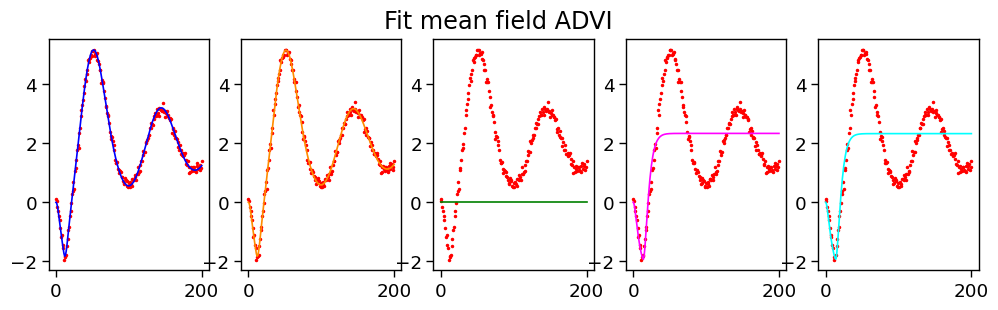

In [77]:
fig, ax = plt.subplots(ncols=5, figsize=(12, 3))
for i in range(5) :
    ax[i].plot(xpy_obs, 'r.', markersize=3)
    ax[i].plot(traces_meanfield[i].posterior['x_hat'].mean(axis=(0, 1)), color=colors[i])
fig.suptitle('Fit mean field ADVI') ;

### Posterior distributions of parameters

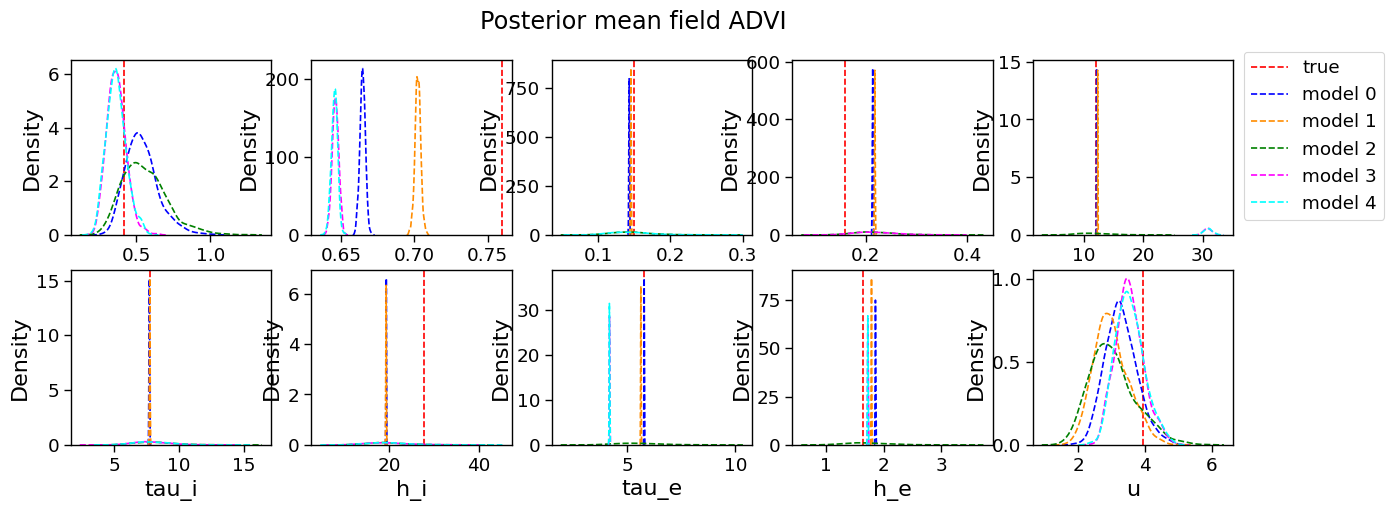

In [78]:
colors = ['blue', 'darkorange', 'green', 'magenta', 'cyan']

fig, ax = plt.subplots(ncols=5, nrows=2, figsize=(15, 5))

for iprm, prm in enumerate(my_var_names) : 
    a = ax[iprm//5, iprm%5]
    a.set_xlabel(prm)
    a.axvline(theta_true[iprm], color='r', label='true', linestyle='--')
    
    for imodel in range(5) :
        try :
            trace = az.extract(traces_meanfield[imodel], var_names=prm)
            sns.kdeplot(trace, linestyle='--', color=colors[imodel], ax=a, label='model ' + str(imodel))
        except :
            pass

ax[0, 4].legend(loc='upper right', bbox_to_anchor=(1.8, 1.1)) 
fig.suptitle('Posterior mean field ADVI');

# Automatic Laplace Approximation

The model taking model_id as an argument cannot be used with numpyro automaic variational guides because the automatic guides will sample for parameters even when they should be set to zero. 

In [79]:
def make_model(data, prior_specs, model_id=0) :
    
    if model_id == 0 :
        
        def model(data, prior_specs, model_id=0):
            #Data
            dt = data['dt']
            ts = data['ts']
            ds = data['ds']
            nt_obs = data['nt_obs']
            x_init = data['x_init']
            obs_err= data['obs_err']
            obs = data['xpy_obs']

            # Prior   
            g_1 = npr.sample('g_1', dist.Gamma(prior_specs['shape'][0], prior_specs['rate'][0]))
            g_2 = npr.sample('g_2', dist.Gamma(prior_specs['shape'][1], prior_specs['rate'][1]))
            g_3 = npr.sample('g_3', dist.Gamma(prior_specs['shape'][2], prior_specs['rate'][2]))
            g_4 = npr.sample('g_4', dist.Gamma(prior_specs['shape'][3], prior_specs['rate'][3]))
            delta = npr.sample('delta', dist.Gamma(prior_specs['shape'][4], prior_specs['rate'][4]))
            tau_i = npr.sample('tau_i', dist.Gamma(prior_specs['shape'][5], prior_specs['rate'][5]))
            h_i = npr.sample('h_i', dist.Gamma(prior_specs['shape'][6], prior_specs['rate'][6]))
            tau_e = npr.sample('tau_e', dist.Gamma(prior_specs['shape'][7], prior_specs['rate'][7]))
            h_e = npr.sample('h_e', dist.Gamma(prior_specs['shape'][8], prior_specs['rate'][8]))
            u = npr.sample('u', dist.Gamma(prior_specs['shape'][9], prior_specs['rate'][9]))

            #Parameters    
            params_samples=[g_1, g_2, g_3, g_4, delta, tau_i,  h_i, tau_e, h_e, u]

            #Forward model
            xpy_hat=ERP_JAXOdeintSimulator(x_init, ts, params_samples)[::ds]

            # Likelihood
            with plate('data', size=nt_obs):
                xpy_model = npr.deterministic('xpy_model', xpy_hat)
                npr.sample('xpy_obs', dist.Normal(xpy_model, obs_err), obs=obs)
                xpy_ppc = npr.sample('xpy_ppc', dist.Normal(xpy_model, obs_err))
                
    elif model_id == 1 :
        
        def model(data, prior_specs, model_id=0):
            #Data
            dt = data['dt']
            ts = data['ts']
            ds = data['ds']
            nt_obs = data['nt_obs']
            x_init = data['x_init']
            obs_err= data['obs_err']
            obs = data['xpy_obs']

            # Prior   
            g_1 = 0
            g_2 = npr.sample('g_2', dist.Gamma(prior_specs['shape'][1], prior_specs['rate'][1]))
            g_3 = npr.sample('g_3', dist.Gamma(prior_specs['shape'][2], prior_specs['rate'][2]))
            g_4 = npr.sample('g_4', dist.Gamma(prior_specs['shape'][3], prior_specs['rate'][3]))
            delta = npr.sample('delta', dist.Gamma(prior_specs['shape'][4], prior_specs['rate'][4]))
            tau_i = npr.sample('tau_i', dist.Gamma(prior_specs['shape'][5], prior_specs['rate'][5]))
            h_i = npr.sample('h_i', dist.Gamma(prior_specs['shape'][6], prior_specs['rate'][6]))
            tau_e = npr.sample('tau_e', dist.Gamma(prior_specs['shape'][7], prior_specs['rate'][7]))
            h_e = npr.sample('h_e', dist.Gamma(prior_specs['shape'][8], prior_specs['rate'][8]))
            u = npr.sample('u', dist.Gamma(prior_specs['shape'][9], prior_specs['rate'][9]))

            #Parameters    
            params_samples=[g_1, g_2, g_3, g_4, delta, tau_i,  h_i, tau_e, h_e, u]

            #Forward model
            xpy_hat=ERP_JAXOdeintSimulator(x_init, ts, params_samples)[::ds]

            # Likelihood
            with plate('data', size=nt_obs):
                xpy_model = npr.deterministic('xpy_model', xpy_hat)
                npr.sample('xpy_obs', dist.Normal(xpy_model, obs_err), obs=obs)
                xpy_ppc = npr.sample('xpy_ppc', dist.Normal(xpy_model, obs_err))
                
    elif model_id == 2 :
    
        def model(data, prior_specs, model_id=0):
            #Data
            dt = data['dt']
            ts = data['ts']
            ds = data['ds']
            nt_obs = data['nt_obs']
            x_init = data['x_init']
            obs_err= data['obs_err']
            obs = data['xpy_obs']

            # Prior   
            g_1 = npr.sample('g_1', dist.Gamma(prior_specs['shape'][0], prior_specs['rate'][0]))
            g_2 = 0
            g_3 = npr.sample('g_3', dist.Gamma(prior_specs['shape'][2], prior_specs['rate'][2]))
            g_4 = npr.sample('g_4', dist.Gamma(prior_specs['shape'][3], prior_specs['rate'][3]))
            delta = npr.sample('delta', dist.Gamma(prior_specs['shape'][4], prior_specs['rate'][4]))
            tau_i = npr.sample('tau_i', dist.Gamma(prior_specs['shape'][5], prior_specs['rate'][5]))
            h_i = npr.sample('h_i', dist.Gamma(prior_specs['shape'][6], prior_specs['rate'][6]))
            tau_e = npr.sample('tau_e', dist.Gamma(prior_specs['shape'][7], prior_specs['rate'][7]))
            h_e = npr.sample('h_e', dist.Gamma(prior_specs['shape'][8], prior_specs['rate'][8]))
            u = npr.sample('u', dist.Gamma(prior_specs['shape'][9], prior_specs['rate'][9]))

            #Parameters    
            params_samples=[g_1, g_2, g_3, g_4, delta, tau_i,  h_i, tau_e, h_e, u]

            #Forward model
            xpy_hat=ERP_JAXOdeintSimulator(x_init, ts, params_samples)[::ds]

            # Likelihood
            with plate('data', size=nt_obs):
                xpy_model = npr.deterministic('xpy_model', xpy_hat)
                npr.sample('xpy_obs', dist.Normal(xpy_model, obs_err), obs=obs)
                xpy_ppc = npr.sample('xpy_ppc', dist.Normal(xpy_model, obs_err))
                
    elif model_id == 3 :
    
        def model(data, prior_specs, model_id=0):
            #Data
            dt = data['dt']
            ts = data['ts']
            ds = data['ds']
            nt_obs = data['nt_obs']
            x_init = data['x_init']
            obs_err= data['obs_err']
            obs = data['xpy_obs']

            # Prior   
            g_1 = npr.sample('g_1', dist.Gamma(prior_specs['shape'][0], prior_specs['rate'][0]))
            g_2 = npr.sample('g_2', dist.Gamma(prior_specs['shape'][1], prior_specs['rate'][1]))
            g_3 = 0
            g_4 = npr.sample('g_4', dist.Gamma(prior_specs['shape'][3], prior_specs['rate'][3]))
            delta = npr.sample('delta', dist.Gamma(prior_specs['shape'][4], prior_specs['rate'][4]))
            tau_i = npr.sample('tau_i', dist.Gamma(prior_specs['shape'][5], prior_specs['rate'][5]))
            h_i = npr.sample('h_i', dist.Gamma(prior_specs['shape'][6], prior_specs['rate'][6]))
            tau_e = npr.sample('tau_e', dist.Gamma(prior_specs['shape'][7], prior_specs['rate'][7]))
            h_e = npr.sample('h_e', dist.Gamma(prior_specs['shape'][8], prior_specs['rate'][8]))
            u = npr.sample('u', dist.Gamma(prior_specs['shape'][9], prior_specs['rate'][9]))

            #Parameters    
            params_samples=[g_1, g_2, g_3, g_4, delta, tau_i,  h_i, tau_e, h_e, u]

            #Forward model
            xpy_hat=ERP_JAXOdeintSimulator(x_init, ts, params_samples)[::ds]

            # Likelihood
            with plate('data', size=nt_obs):
                xpy_model = npr.deterministic('xpy_model', xpy_hat)
                npr.sample('xpy_obs', dist.Normal(xpy_model, obs_err), obs=obs)
                xpy_ppc = npr.sample('xpy_ppc', dist.Normal(xpy_model, obs_err))
                
    elif model_id == 4 :
    
        def model(data, prior_specs, model_id=0):
            #Data
            dt = data['dt']
            ts = data['ts']
            ds = data['ds']
            nt_obs = data['nt_obs']
            x_init = data['x_init']
            obs_err= data['obs_err']
            obs = data['xpy_obs']

            # Prior   
            g_1 = npr.sample('g_1', dist.Gamma(prior_specs['shape'][0], prior_specs['rate'][0]))
            g_2 = npr.sample('g_2', dist.Gamma(prior_specs['shape'][1], prior_specs['rate'][1]))
            g_3 = npr.sample('g_3', dist.Gamma(prior_specs['shape'][2], prior_specs['rate'][2]))
            g_4 = 0
            delta = npr.sample('delta', dist.Gamma(prior_specs['shape'][4], prior_specs['rate'][4]))
            tau_i = npr.sample('tau_i', dist.Gamma(prior_specs['shape'][5], prior_specs['rate'][5]))
            h_i = npr.sample('h_i', dist.Gamma(prior_specs['shape'][6], prior_specs['rate'][6]))
            tau_e = npr.sample('tau_e', dist.Gamma(prior_specs['shape'][7], prior_specs['rate'][7]))
            h_e = npr.sample('h_e', dist.Gamma(prior_specs['shape'][8], prior_specs['rate'][8]))
            u = npr.sample('u', dist.Gamma(prior_specs['shape'][9], prior_specs['rate'][9]))

            #Parameters    
            params_samples=[g_1, g_2, g_3, g_4, delta, tau_i,  h_i, tau_e, h_e, u]

            #Forward model
            xpy_hat=ERP_JAXOdeintSimulator(x_init, ts, params_samples)[::ds]

            # Likelihood
            with plate('data', size=nt_obs):
                xpy_model = npr.deterministic('xpy_model', xpy_hat)
                npr.sample('xpy_obs', dist.Normal(xpy_model, obs_err), obs=obs)
                xpy_ppc = npr.sample('xpy_ppc', dist.Normal(xpy_model, obs_err))
                
                
    return model

In [80]:
lr = 0.0005
n_iters = 200000
optimizer = Adam(lr)
rng_key = jax.random.PRNGKey(1)

In [81]:
elbos_laplace = []
traces_laplace = []

for imodel in range(5) :
    
    #prior and initialization
    n_ = 100
    prior_predictive = Predictive(model, num_samples=n_)
    prior_predictions = prior_predictive(rng_key, data, prior_specs,  model_id=imodel)
    tails_5th_percentile=tails_percentile(my_var_names, prior_predictions, 0.05)
    init_to_low_prob = init_to_value(values=tails_5th_percentile)
    
    #define model and guide
    model = make_model(data, prior_specs, model_id=imodel)
    guide = AutoLaplaceApproximation(model)
    svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

    #RUN SVI 
    time.time()
    svi_res = svi.run(rng_key, n_iters, data, prior_specs, model_id=imodel, stable_update=True)
    print("Model " + str(imodel) + " with SVI Laplace took (sec):" , (time.time() - start_time))
    elbos_laplace.append(-svi_res.losses)
    laplace_post = guide.sample_posterior(rng_key, svi_res.params, sample_shape=(1, 800))
    traces_laplace.append(az.from_dict(laplace_post))

100%|█| 200000/200000 [01:22<00:00, 2437.86it/s, init loss: 73715.1562, avg. los


Model 0 with SVI Laplace took (sec): 254.33279991149902


100%|█| 200000/200000 [01:21<00:00, 2440.71it/s, init loss: 3803525.7500, avg. l


Model 1 with SVI Laplace took (sec): 356.8067264556885


100%|█| 200000/200000 [01:22<00:00, 2437.02it/s, init loss: 75915.1406, avg. los


Model 2 with SVI Laplace took (sec): 458.2920067310333


100%|█| 200000/200000 [01:22<00:00, 2431.37it/s, init loss: 60636.2656, avg. los


Model 3 with SVI Laplace took (sec): 558.0872790813446


100%|█| 200000/200000 [01:20<00:00, 2490.70it/s, init loss: 60643.1914, avg. los


Model 4 with SVI Laplace took (sec): 655.8782706260681


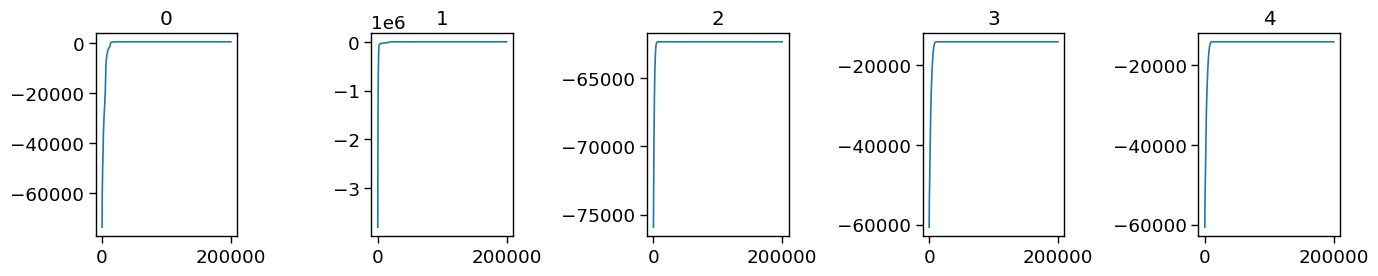

In [82]:
fig, ax = plt.subplots(ncols=5, figsize=(14, 3))
for i in range(5) :
    ax[i].plot(elbos_laplace[i])
    ax[i].set(title=str(i))
fig.tight_layout()

In [83]:
max_elbo_laplace = []
for i in range(5) :
    max_elbo_laplace.append(np.max(elbos_laplace[i]))
max_elbo_laplace = np.array(max_elbo_laplace).flatten()

In [84]:
max_elbo_laplace

array([   459.07812,    458.72565, -62372.42   , -14153.323  ,
       -14153.351  ], dtype=float32)

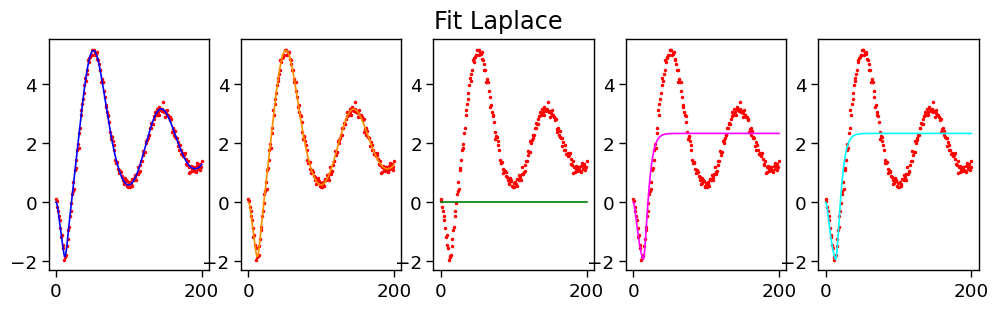

In [85]:
fig, ax = plt.subplots(ncols=5, figsize=(12, 3))
for i in range(5) :
    ax[i].plot(xpy_obs, 'r.', markersize=3)
    ax[i].plot(traces_laplace[i].posterior['xpy_model'].mean(axis=(0, 1)), color=colors[i])
fig.suptitle('Fit Laplace') ;

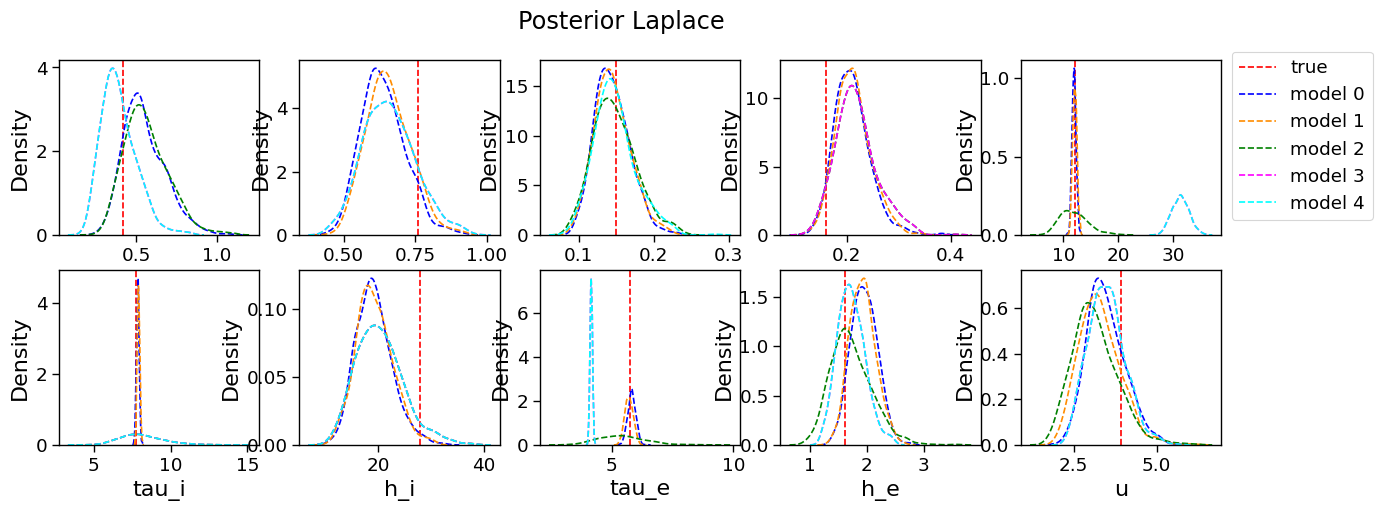

In [86]:
fig, ax = plt.subplots(ncols=5, nrows=2, figsize=(15, 5))

for iprm, prm in enumerate(my_var_names) : 
    a = ax[iprm//5, iprm%5]
    a.set_xlabel(prm)
    a.axvline(theta_true[iprm], color='r', label='true', linestyle='--')
    
    for imodel in range(5) :
        try :
            trace = az.extract(traces_laplace[imodel], var_names=prm)
            sns.kdeplot(trace, linestyle='--', color=colors[imodel], ax=a, label='model ' + str(imodel))
        except :
            pass

ax[0, 4].legend(loc='upper right', bbox_to_anchor=(1.8, 1.1)) 
fig.suptitle('Posterior Laplace');

## Sumarizing max ELBO as a model comparison quantity

In [87]:
models_ic_advi = pd.DataFrame({'max_elbo_meanfield': -max_elbo_meanfield_ordered,
                               'max_elbo_fullrank': -max_elbo_fullrank_ordered,
                               'max_elbo_laplace': -max_elbo_laplace,
                               'model': ['full model', 'g_1 = 0', 'g_2 = 0', 'g_3 = 0', 'g_4 = 0']})

In [88]:
models_ic_advi.to_csv('models_ic_advi.csv')

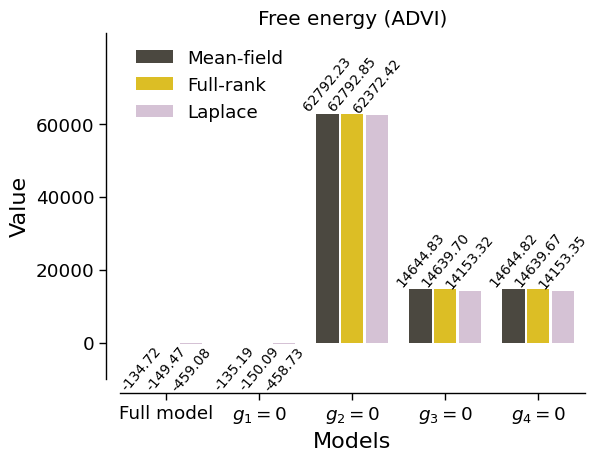

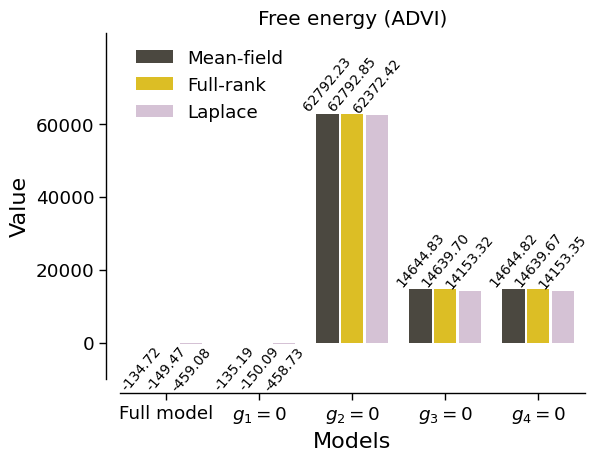

In [89]:
colors_alg = ['#4d493e', '#fad207', 'thistle', '#9e906f']
model_names_l = ['Full model', r'$g_1 = 0$', r'$g_2 = 0$', r'$g_3 = 0$', r'$g_4 = 0$']

fig, ax = plt.subplots(figsize=(6, 4.5))
sns.barplot(models_ic_advi.melt('model', var_name='criterion'), 
            x='model', y='value', hue='criterion', palette=colors_alg, ax=ax, gap=.1)
for i in range(3) :
    ax.bar_label(ax.containers[i], fmt='%.2f', fontsize=10, rotation=50)

ax.set_ylim([-10000, 85000])
ax.set_yticks(range(0, 65000, 20000))   
ax.set_xticks(range(5))
ax.set_xticklabels(model_names_l)
ax.set_xlabel('Models')
ax.set_ylabel('Value')

h, l = ax.get_legend_handles_labels()
ax.legend(frameon=False, handles=h, labels=['Mean-field', 'Full-rank', 'Laplace'], loc='upper left')
ax.set_title('Free energy (ADVI)')
sns.despine(offset=10) ;
fig

# Final summary: HMC and ADVI

In [90]:
models_ic = pd.read_csv('models_ic.csv', index_col=0)
models_ic_advi = pd.read_csv('models_ic_advi.csv', index_col=0)

In [91]:
sns.reset_defaults()
sns.set_context("paper", font_scale=1.5, rc={"axes.labelsize":16})
fmts = ['.png', '.pdf', '.svg', '.eps']

In [92]:
model_names_l = ['Full model', r'$g_1 = 0$', r'$g_2 = 0$', r'$g_3 = 0$', r'$g_4 = 0$']

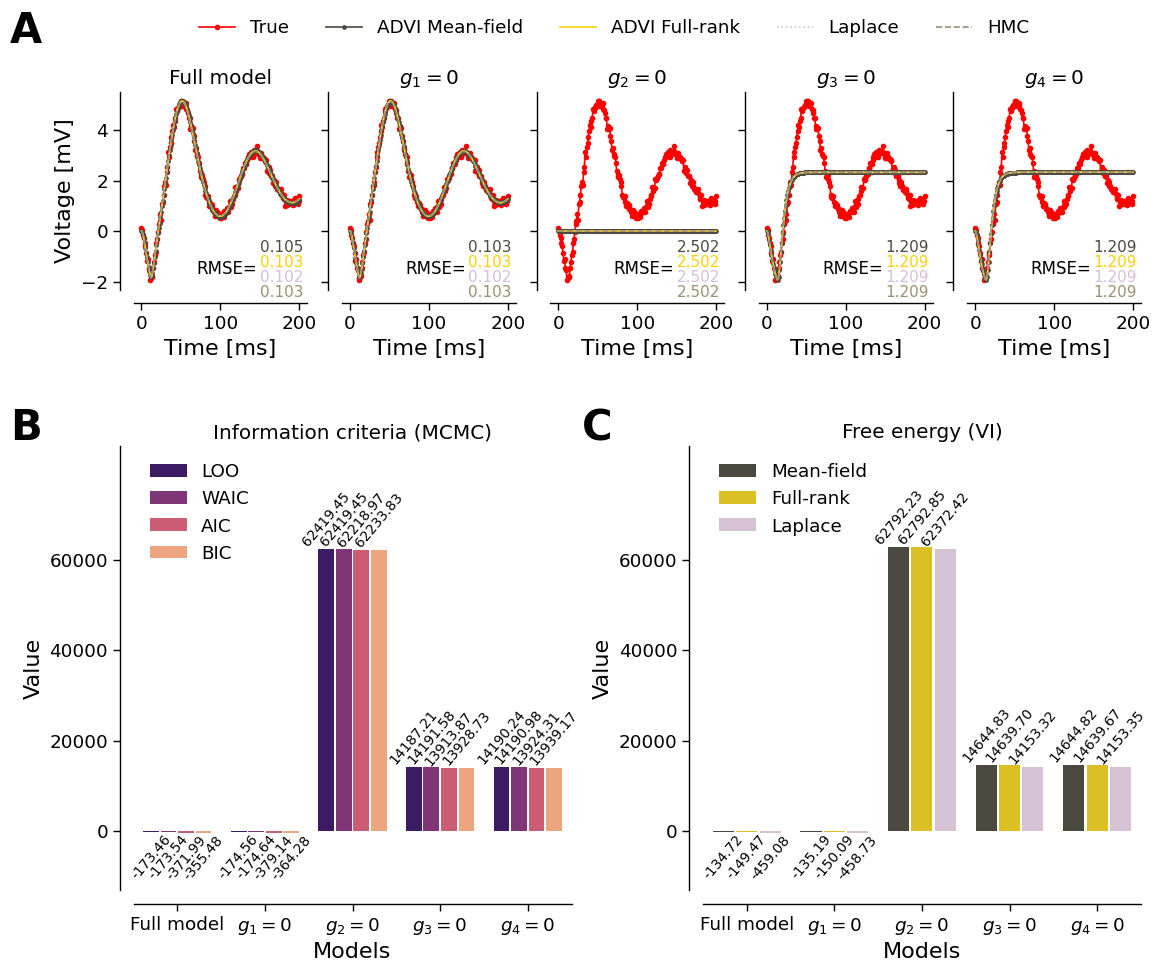

In [93]:
fig = plt.figure(figsize=(13, 9))
(topfig, botfig) = fig.subfigures(2, 1, height_ratios=[1, 2.5])
topaxs = topfig.subplots(1, 5, sharex=True, sharey=True)
botaxs = botfig.subplots(1, 2)

colors_alg = ['#4d493e', '#fad207', 'thistle', '#9e906f']

ax = botaxs[0]
sns.barplot(models_ic.melt('model', var_name='criterion'), 
            x='model', y='value', hue='criterion', palette='magma', ax=ax, gap=.1)
for i in range(4) :
    ax.bar_label(ax.containers[i], fmt='%.2f', fontsize=10, rotation=50)
ax.set_ylim([-13000, 85000])
ax.set_yticks(range(0, 65000, 20000))   
ax.set_xticks(range(5))
ax.set_xticklabels(model_names_l)
ax.set_xlabel('Models')
ax.set_ylabel('Value')
h, l = ax.get_legend_handles_labels()
ax.legend(frameon=False, handles=h, labels=['LOO', 'WAIC', 'AIC', 'BIC'], loc='upper left')
ax.set_title('Information criteria (MCMC)')


ax = botaxs[1]
sns.barplot(models_ic_advi.melt('model', var_name='criterion'), 
            x='model', y='value', hue='criterion', 
            #hue_order=['max_elbo_laplace', 'max_elbo_meanfield', 'max_elbo_fullrank'], 
                       palette=colors_alg, ax=ax, gap=.1)
for i in range(3) :
    ax.bar_label(ax.containers[i], fmt='%.2f', fontsize=10, rotation=50)

            
ax.set_ylim([-13000, 85000])
ax.set_yticks(range(0, 65000, 20000))   
ax.set_xticks(range(5))
ax.set_xticklabels(model_names_l)
ax.set_xlabel('Models')
ax.set_ylabel('Value')
h, l = ax.get_legend_handles_labels()
ax.legend(frameon=False, handles=h, labels=['Mean-field', 'Full-rank', 'Laplace'], loc='upper left')
ax.set_title('Free energy (VI)')


ax = topaxs
for i in range(5) :
    ax[i].plot(xpy_obs, color='red', marker='.', markersize=6, label='True')
    ax[i].plot(traces_meanfield[i].posterior['x_hat'].mean(axis=(0, 1)), 
               '.-', color=colors_alg[0], label='ADVI Mean-field')
    ax[i].plot(traces_fullrank[i].posterior['x_hat'].mean(axis=(0, 1)), 
               '-', color=colors_alg[1], label='ADVI Full-rank')
    ax[i].plot(traces_laplace[i].posterior['xpy_model'].mean(axis=(0, 1)), 
               ':', color=colors_alg[2], label='Laplace')
    ax[i].plot(models_traces[i].posterior['xpy_model'].mean(axis=(0, 1)), 
               '--', color=colors_alg[3], label='HMC')
    
    
    ax[i].text(70, -1.7, 'RMSE=', size=12)
    ax[i].text(150, -0.8, 
               str(np.round(rmse(
                   traces_meanfield[i].posterior['x_hat'].mean(axis=(0, 1)).values, xpy_obs), 3)),
              size=11, color=colors_alg[0])
    ax[i].text(150, -1.4, 
               str(np.round(rmse(
                   traces_fullrank[i].posterior['x_hat'].mean(axis=(0, 1)).values, xpy_obs), 3)),
              size=11, color=colors_alg[1])
    ax[i].text(150, -2, 
               str(np.round(rmse(
                   traces_laplace[i].posterior['xpy_model'].mean(axis=(0, 1)).values, xpy_obs), 3)),
              size=11, color=colors_alg[2])
    ax[i].text(150, -2.6, 
               str(np.round(rmse(
                   models_traces[i].posterior['xpy_model'].mean(axis=(0, 1)).values, xpy_obs), 3)),
              size=11, color=colors_alg[3])
    
    
    ax[i].set_title(model_names_l[i])
    ax[i].set_xlabel('Time [ms]')
ax[0].set_ylabel('Voltage [mV]') 
ax[-1].legend(bbox_to_anchor=(0.45, 1.45), frameon=False, ncols=5)


topfig.text(0.03, 1.07, 'A', size=30, weight='bold')
botfig.text(0.03, 0.81, 'B', size=30, weight='bold')
botfig.text(0.47, 0.81, 'C', size=30, weight='bold')


botfig.subplots_adjust(wspace=0.3, top=0.8)
sns.despine(fig, offset=10)
fig

In [94]:
for fmt in fmts :
    fig.savefig('./figs/model_comparison_laplace' + fmt, bbox_inches='tight', dpi=500)

In [95]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Wed Jul 10 2024

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 8.24.0

seaborn   : 0.13.2
sys       : 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
cmdstanpy : 1.2.2
numpyro   : 0.14.0
pandas    : 2.2.2
numpy     : 1.24.3
matplotlib: 3.8.4
arviz     : 0.18.0
jax       : 0.4.23

Watermark: 2.4.3

